**Authors**: Carayon Chloé - Taillieu Victor

**Date**: 07/01/2021

---
# LAB4 Machine Learning: Neural Network
---

## Introduction

In this last lab, we have to implement from scratch an image classifier using a feed-forward neural network (FFNN),
optimize it and then compare results by increasing the number of layers.

We firstly import the libraries needed for the lab.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

## 1. Exploration of dataset

This dataset is composed of features stored in features.txt and associated labels stored in labels.txt. We modify the label values and replace the 10 by 0.

The features represent images and associated labels which are between 0 and 9.
We can see their representation by plotting the features below.

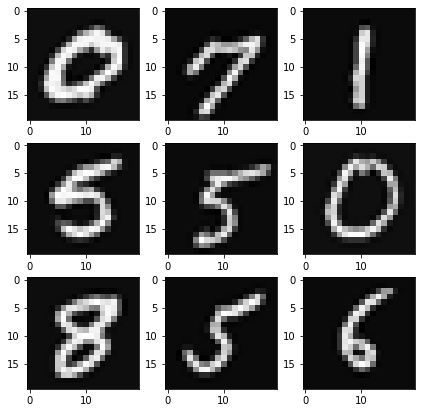

In [2]:
features = pd.read_csv("data/features.txt", header=None)
labels = pd.read_csv("data/labels.txt", header=None).replace(10, 0)

np.random.seed(1)
plt.figure(figsize=(7, 7))

for i in range(9):
    plt.subplot(331 + i)
    plt.imshow(features.iloc[np.random.randint(0, 5000)].values.reshape(20, 20, order="F"), cmap="gray")

plt.show()

We have an equally repartition of the label class values which will allow us to obtain better results for the image classifier.

In [247]:
labels[0].value_counts()

7    500
3    500
6    500
2    500
9    500
5    500
1    500
8    500
4    500
0    500
Name: 0, dtype: int64

We decided to merge in a unique dataset the features and the labels.

In [3]:
df = features.copy()
df["label"] = labels
df

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,label
0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,9
4996,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,9
4997,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,9
4998,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,9


## 2. FFNN Implementation

To implement our image classifier with a FFNN, we created two different classes, **Layer** and **NeuralNetwork**.      
In this first part, the **NeuralNetwork** class is only working for 3 layers: an input layer, a hidden layer and an output layer.  
We will then generalize in our second part this class in order to use it for as many layers as we want. 

### 2.1. Layer class

**Layer** class is used to instanciate a layer, we have created also two child classes: **InputLayer** and **OutputLayer**.  
Depending on the classes, the forward and backward functions may be different.

We will explain the several methods of our classes and then present the entire code of the class.   

#### 2.1.1. Initialization of Layer classes

The input layer is not initialized because it does not have associated weights. 

##### Hidden layers and output layer 

In order to create those layers, we need: the number of inputs `n_inputs` and the number of nodes `n_neurons`. 
One can also define a random state `random_state`, with a default value at 42. Using `random_state`, we ensure that the splits we generate
for test and train dataset will be reproducible.

``` python 
    np.random.seed(random_state)
```

We decided to create the weight matrix `w` during the initialization of the hidden and output layers. 
We instance the weight `w` based on our parameters. 

``` python 
    self.w = np.matrix(np.random.randn(n_neurons, n_inputs + 1))
```

##### Input layer 

As the input layer takes the values of the features, we don't need to instance it with a number of inputs and nodes. 
We also won't create the weight matrix `w` in this layer, as it is created in hidden and output layers. 


#### 2.1.2. Sigmoid and derivative of the sigmoid

We decide to use the sigmoid as the **activation function**.  
The sigmoid is used during the forward propagation whereas the derivative of the 
sigmoid is used for the backward propagation.

##### Sigmoid 

The formula of the sigmoid is $ a^{i} = g(z^{i}) = \frac{1}{1 + e^{-z^{i}}}$.
Which gives us:
``` python
    1 / (1 + np.exp(-x))
```

##### Derivative of the sigmoid 

For the derivative of the sigmoid, we have :
$ g'(z^{i}) = a^{i} * (1 - a^{i}) $

In python, we have to use `np.multiply` to do the element wise multiplication:

``` python
    np.multiply(x, (1 - x)
```

#### 2.1.3. Forward propagation 

Depending on the type of layer, the calculus of the forward propagation changes.

##### Input layer 

For the input layer, as our input data corresponds to the features values, we only have to save them as the output of the forward function.  
In fact, we have the following formula:   
$ a^{1} = x $ with $x$ the inputs and $a$ the outputs of the layer. 

We use `np.insert()` in order to insert a line of ones corresponding to the bias.

``` python 
    self.output = np.insert(inputs, 0, 1, axis=0)
```

##### Hidden layer and output layer 

Whereas, for hidden and output layer, we have to do:    
$ a^{i} =  sigmoid(z^{i}) $    
with $ z^{i} = W^{i-1} a^{i-1}$ 

Which gives us:
``` python 
    z = self.w * inputs
    a = self.sigmoid(z)
```

For the hidden layer, we have to add a line of `1` in order to create the bias.  
```python 
    self.output = np.insert(a, 0, 1, axis=0)
```

#### 2.1.4. Backward propagation 

For the backward propagation, we go from the end to the beginning of the FFNN, we won't have
the same formula for the output layer and the hidden and input layers. 

When we implement the NeuralNetwork, we have to update the weight associated to layers. 
But if we only focus on the layers, during the backward propagation, we only have to update the errors.

##### Output layer 

For the output layer, we know that:   
$ \delta^{n} = a{^n} - y $

For the function, we have a parameter, `y`  corresponding to the labels outputs of the dataset. 

We reuse $a$, calculated during the forward propagation, and stored in `self.output`. 

``` python
    self.error = self.output - y
```

##### Input layer and hidden layer 

For the input and hidden layers, the calculus were more complex.  
With $i < n $ :
$ \delta^{i} = (W^{i})^{T}.delta^{i+1} * sigmoid' (W^{i} a^{i}) $   

The parameters of the function are `next_w` and `next_error` which are the respective values of $W^{i}$ 
and $delta^{i+1}$.

To do so, we decide to firstly calculate the derivate and stored it in `deriv`, and then
calculate the error stored in `self.error`.

We have to use `np.multiply` as we have to do element-wise multiplication.

``` python
    deriv = self.sigmoid_deriv(self.output)
    error = np.multiply(next_w.T * next_error, deriv)
```

Moreover, we have to drop the first line of the previous error due to the bias to match the dimension of `self.output`. 
```python
    self.error = np.delete(error, 0, axis=0)
```

#### 2.1.5. Code of the layer class


In [4]:
class Layer:
    def __init__(self, n_inputs, n_neurons, random_state=42):
        np.random.seed(random_state)
        self.w = np.matrix(np.random.randn(n_neurons, n_inputs + 1))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_deriv(self, x):
        return np.multiply(x, (1 - x))

    def forward(self, inputs):
        z = self.w * inputs
        a = self.sigmoid(z)
        self.output = np.insert(a, 0, 1, axis=0)

    def backward(self, next_w, next_error):
        deriv = self.sigmoid_deriv(self.output)
        error = np.multiply(next_w.T * next_error, deriv)
        self.error = np.delete(error, 0, axis=0)
        
class InputLayer(Layer):
    def __init__(self):
        pass

    def forward(self, inputs):
        self.output = np.insert(inputs, 0, 1, axis=0)

class OutputLayer(Layer):
    def forward(self, inputs):
        z = self.w * inputs
        a = self.sigmoid(z)
        self.output = a
    
    def backward(self, y):
        self.error = self.output - y

### 2.2. NeuralNetwork class

NeuralNetwork class is used to instance feed forward neural network (FFNN).  
We implement it using 3 layers: one input layer, one hidden layer and one output layer.

#### 2.2.1. Initialization of NeuralNetwork

##### Initialization 

For the initialization, we need 3 parameters: the features and labels stored in `df`, the number of neurons `n_neurons` and  the random state `random_state` and `test_size` which 
with respectivelly default values at 42 and 0,2.

As we have done before in the previous lab, we take the dataset as a parameter and split it in X and y train and test dataset.
`X`is our features and `y` the labels: the last column of the dataset. 
We save the number of observations as `m` and the number of features in `n` based on `X` shape.  
We also set the number of output classes in `n_classes`.

``` python
        X = df.iloc[:, :-1]
        y = df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        self.m, self.n = X_train.shape
        self.n_classes = y.nunique()
```
 
We normalize `X.train`and `X_test` and dummies `y_train`and `y_test` but keep the label values in `labels_train`and `labels_test`
to use them later.

``` python
        self.X_train = self.normalizeFeatures(X_train, fit=True).T
        self.X_test = self.normalizeFeatures(X_test).T
        self.y_train = np.matrix(pd.get_dummies(y_train)).T
        self.labels_train = np.matrix(y_train)
        self.y_test = np.matrix(pd.get_dummies(y_test)).T
        self.labels_test = np.matrix(y_test)
```

Finally, we create the 3 layers of our FFNN, which are: one input layer, one hidden layer and one output layer.
Knowing that for the hidden layer, we can't exceed the number of features. And we can't exceed the number of nodes for the output layer
corresponding to the number of classes labels.

``` python
        self.layer0 = InputLayer()
        self.layer1 = Layer(self.n, n_neurons)
        self.layer2 = OutputLayer(n_neurons, self.n_classes)
```

##### Normalization  

For the normalization, we adapt the function used in the previous lab. We store for each column its associated minimum and maximum values.  

But this time, we have to take into consideration the possibility to have equal minimum and maximum. 
This brings us to an issue solved thanks to the lambda mapping. 
``` python
    self.scaling = list(map(lambda x: (0, 1) if x[0] == x[1] else (x[0], x[1]), self.scaling))
```

We then normalize our features and return the normalize features:

``` python
    minmax = list(zip(*self.scaling))
    min, max = np.array(minmax[0]), np.array(minmax[1])
    np.matrix((X - min) / (max - min))
```


#### 2.2.2. Forward, Backward propagation and Cost function

##### Forward 

For the forward propagation, we have to go from left to right in our FFNN. We use the **forward** function of the Layer class and 
its child classes. It actualizes the output variable of each layer.

For each layer, we use the output of the previous layer, which gives us:

``` python
    self.layer0.forward(self.X)
    self.layer1.forward(self.layer0.output)
    self.layer2.forward(self.layer1.output)
```

##### Backward 

Whereas for the backward propagation, we have to go from right to left in our FFNN. 

As we don't have weight on layer0 (the input layer), we only have to calculate the backward propagation 
of the output and hidden layers.  
We use the **backward** function of Layer class and its child class, which actualizes the error.

``` python 
    self.layer2.backward(self.y_train)
    self.layer1.backward(self.layer2.w, self.layer2.error)
```

##### Cost function 

Finally, for the cost function, based on the formula below:   
$ J = \frac{-1}{m} [ \sum_{i = 1}^{m} \sum_{k = 1}^{k}  y^{i}_k log(h_w(x^{i}))_k + (1- y^{i}_k) log(1 - h_w(x^{i}))_k  ] $

Using `np.multiply`, we ensure element wise multiplication:

``` python
    y, m = self.y_train, self.m
    -1 / m * np.sum(np.multiply(y, np.log(y_pred)) + np.multiply((1 - y), np.log(1 - y_pred)))
```

#### 2.2.3. Gradient descent 

##### Gradient

To calculate the global gradient, we calculate the gradient of each output and hidden layers.
It is given by:  
$ \Delta_{ij}^{l} = \delta_i^{l+1}(a_j^{l})^T  $ 

``` python
    grad0 = self.layer1.error * self.layer0.output.T
    grad1 = self.layer2.error * self.layer1.output.T
```

We use it for the update of weight matrix.

##### Gradient descent 

For the gradient descent, we have to define some hyperparameters such as the number of epochs, the threshold and the $\alpha$ value.
And we create lists to store the accuracy and cost result to plot them latter.  
We need the following variables:
``` python
    i = 0
    self.J = []
    self.train_accuracy = []
    self.test_accuracy = []
```

We do the gradient descent until convergence or until the number of epochs.

We repeat until convergence the following steps:  
The forward and backward propagation, followed by the cost function. 
We store each result of the cost function in `J` in order to plot it after and see the Cost.
``` python
    while True:
        i += 1
        self.forward(self.X_train)
        self.backward()

        self.J.append(self.costFunction(self.layer2.output))
```

Then, we update the values of the weight matrix in layer1 and layer2, as we have:  
$ w^l = w^l - \alpha\Delta^l $

``` python
    grads = self.gradient()

    self.layer1.w -= alpha * grads[0]
    self.layer2.w -= alpha * grads[1]
```

Calculate the train and test accuracy:
```python 
    self.train_accuracy.append(self.accuracy(self.X_train, self.labels_train))
    self.test_accuracy.append(self.accuracy(self.X_test, self.labels_test))
```

Finally, if the Cost function convergences, we stop:
``` python    
    if len(self.J) > 1:
        if abs(self.J[-1] - self.J[-2]) < threshold or i == epochs:
            break
```

#### 2.2.4. Confusion matrix 

##### predict 

We redo the forward propagation and use `argmax` to obtain for each column, the greatest number corresponding to the most predicted value.
Predict is used for the calculation of the accuracy.

``` python
    self.forward(X)
    np.array(self.layer2.output).argmax(axis=0)
``` 

##### Confusion 

For the confusion matrix, we present a matrix of size 10x10 to see the prediction of each class.

``` python
    y_pred = self.predict(X)
    
    matrix = np.zeros((self.n_classes, self.n_classes), dtype=int)
        
    for i in range(len(y_pred)):
        matrix[y.T[i], y_pred[i]] += 1
``` 

##### Accuracy 

The accuracy is the proportion of correct predictions over total predictions.  
It is perfect for classes which are equally important. 

``` python
    (self.predict(X) == y).mean()
``` 

#### 2.2.5. Code of the NeuralNetwork class


In [5]:
class NeuralNetwork:
    def __init__(self, df, n_neurons, test_size=0.2, random_state=42):
        X = df.iloc[:, :-1]
        y = df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        self.m, self.n = X_train.shape
        self.n_classes = y.nunique()
        
        self.X_train = self.normalizeFeatures(X_train, fit=True).T
        self.X_test = self.normalizeFeatures(X_test).T
        self.y_train = np.matrix(pd.get_dummies(y_train)).T
        self.labels_train = np.matrix(y_train)
        self.y_test = np.matrix(pd.get_dummies(y_test)).T
        self.labels_test = np.matrix(y_test)
        
        self.layer0 = InputLayer()
        self.layer1 = Layer(self.n, n_neurons)
        self.layer2 = OutputLayer(n_neurons, self.n_classes)

    def normalizeFeatures(self, X, fit=False):
        if fit:
            scaling = list(zip(X.min(), X.max()))
            self.scaling = list(map(lambda x: (0, 1) if x[0] == x[1] else (x[0], x[1]), scaling))

        minmax = list(zip(*self.scaling))
        min, max = np.array(minmax[0]), np.array(minmax[1])
        
        return np.matrix((X - min) / (max - min))

    def gradientDescent(self, alpha=1e-3, threshold=1e-5, epochs=1000):
        i = 0
        self.J = []
        self.train_accuracy = []
        self.test_accuracy = []
    
        while True:
            i += 1
            self.forward(self.X_train)
            self.backward()
        
            self.J.append(self.costFunction(self.layer2.output))

            grads = self.gradient()

            self.layer1.w -= alpha * grads[0]
            self.layer2.w -= alpha * grads[1]
            
            self.train_accuracy.append(self.accuracy(self.X_train, self.labels_train))
            self.test_accuracy.append(self.accuracy(self.X_test, self.labels_test))
            
            if len(self.J) > 1:
                if abs(self.J[-1] - self.J[-2]) < threshold or i == epochs:
                    break

    def plotCostAccuracy(self):
        try:
            plt.figure(figsize=(12, 4))
            plt.subplot(121)
            plt.plot(self.J)
            plt.title("Value of the cost function over epochs")
            plt.xlabel("epoch")
            plt.ylabel("cost function value")
            
            plt.subplot(122)
            plt.plot(self.train_accuracy, label="train")
            plt.plot(self.test_accuracy, label="test")
            plt.title("Accuracy over epochs")
            plt.xlabel("epoch")
            plt.ylabel("accuracy")
            plt.legend()
            plt.show()
        except AttributeError:
            print("No gradient descent was performed")

    def costFunction(self, y_pred):
        y, m = self.y_train, self.m
    
        return -1 / m * np.sum(np.multiply(y, np.log(y_pred)) + np.multiply((1 - y), np.log(1 - y_pred)))

    def forward(self, x):
        self.layer0.forward(x)
        self.layer1.forward(self.layer0.output)
        self.layer2.forward(self.layer1.output)

    def backward(self):
        self.layer2.backward(self.y_train)
        self.layer1.backward(self.layer2.w, self.layer2.error)

    def gradient(self):
        grad0 = self.layer1.error * self.layer0.output.T
        grad1 = self.layer2.error * self.layer1.output.T

        return grad0, grad1
    
    def confusion(self, X, y):
        y_pred = self.predict(X)
        
        matrix = np.zeros((self.n_classes, self.n_classes), dtype=int)
        
        for i in range(len(y_pred)):
            matrix[y.T[i], y_pred[i]] += 1
        
        return matrix

    def accuracy(self, X, y):
        return (self.predict(X) == y).mean()
        
    def predict(self, X):
        self.forward(X)
        return np.array(self.layer2.output).argmax(axis=0)

## 3. Applying the FFNN algorithm to the dataset

We can now use those classes to apply FFNN on our dataset.

### 3.1. Initialization 

For the **train and test**, the separation is done inside the class **NeuralNetwork** and have a default value `test_size=0.2`.

Let's select the most accurate number of neurons for the hidden layer which has to be between the number of neurons of the input and output layers.

NN 10 neurons
Train accuracy: 0.802
Test accuracy: 0.795


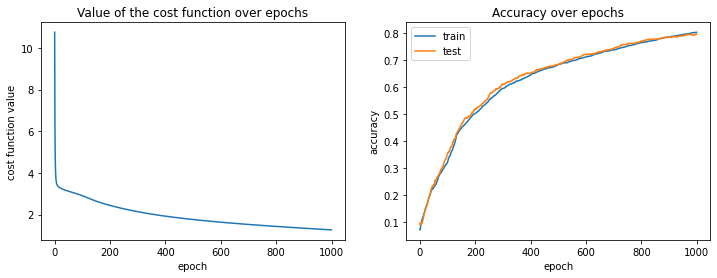


NN 50 neurons
Train accuracy: 0.9075
Test accuracy: 0.878


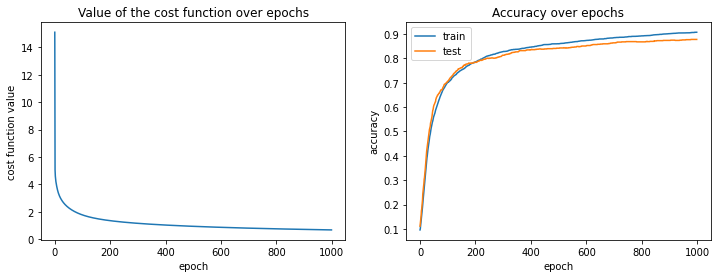


NN 100 neurons
Train accuracy: 0.9265
Test accuracy: 0.874


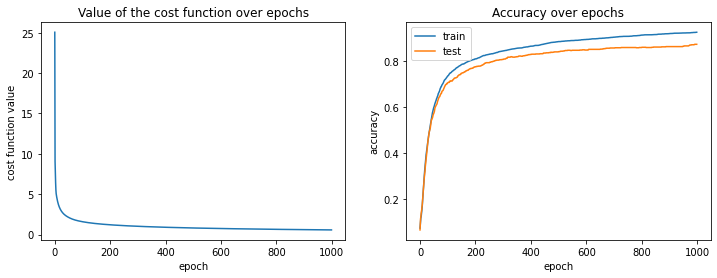

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in log
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in multiply

NN 400 neurons
Train accuracy: 0.9815
Test accuracy: 0.904


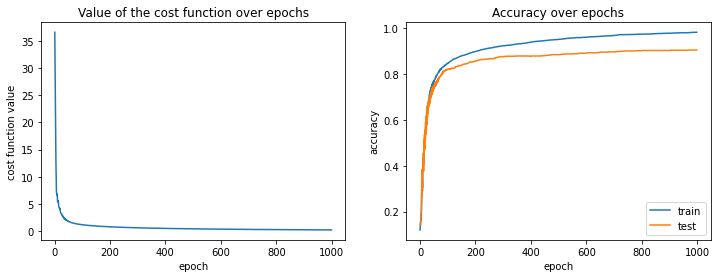

In [6]:
NN10 = NeuralNetwork(df, 10)
NN10.gradientDescent(alpha=1e-4, epochs=1000)
print("NN 10 neurons")
print("Train accuracy:", NN10.accuracy(NN10.X_train, NN10.labels_train))
print("Test accuracy:", NN10.accuracy(NN10.X_test, NN10.labels_test))
NN10.plotCostAccuracy()

NN50 = NeuralNetwork(df, 50)
NN50.gradientDescent(alpha=1e-4, epochs=1000)
print("\nNN 50 neurons")
print("Train accuracy:", NN50.accuracy(NN50.X_train, NN50.labels_train))
print("Test accuracy:", NN50.accuracy(NN50.X_test, NN50.labels_test))
NN50.plotCostAccuracy()

NN100 = NeuralNetwork(df, 100)
NN100.gradientDescent(alpha=1e-4, epochs=1000)
print("\nNN 100 neurons")
print("Train accuracy:", NN100.accuracy(NN100.X_train, NN100.labels_train))
print("Test accuracy:", NN100.accuracy(NN100.X_test, NN100.labels_test))
NN100.plotCostAccuracy()

NN400 = NeuralNetwork(df, 400)
NN400.gradientDescent(alpha=1e-4, epochs=1000)
print("\nNN 400 neurons")
print("Train accuracy:", NN400.accuracy(NN400.X_train, NN400.labels_train))
print("Test accuracy:", NN400.accuracy(NN400.X_test, NN400.labels_test))
NN400.plotCostAccuracy()

If we compare those 4 results, we clearly see that NN10 gives the worst results for the accuracy of the train and test sets with respectively 0.80 and 0.79.

For NN100 and NN400 models, it overfits of 0.05 and 0.08 as we can see on the accuracy plot.

By comparison, NN50 obtains the most acceptable results, that's why we decided to take **50 neurons** for the hidden layer.

### 3.2. Gradient descent

We can now test the gradient descent for this FFNN and take $\alpha = 10^{-3} $ and $epoch = 1000 $.  
Depending on the result of the accuracy and the plot of the cost function, we can change the hyperparameters to improve the FFNN.

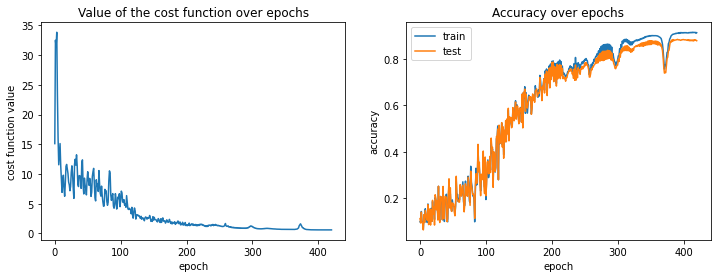

In [7]:
NN = NeuralNetwork(df, 50)
NN.gradientDescent(alpha=1e-3, epochs=1000)
NN.plotCostAccuracy()

We obtain the above result, as we can see, the learning rate is too high for the cost function. 

We should take a lower learning rate, such as $\alpha = 10^{-4}$

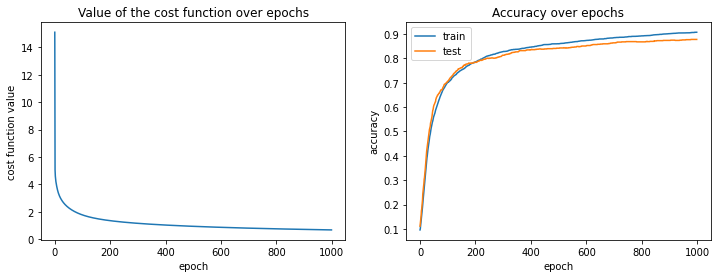

In [8]:
NN = NeuralNetwork(df, 50)
NN.gradientDescent(alpha=1e-4, epochs=1000)
NN.plotCostAccuracy()

With $ \alpha = 10^{-4}$, the cost function is better.

As we selected **50** neurons for the hidden layer and choose a correct value for $\alpha$, we can now
do the gradient descent until convergence.

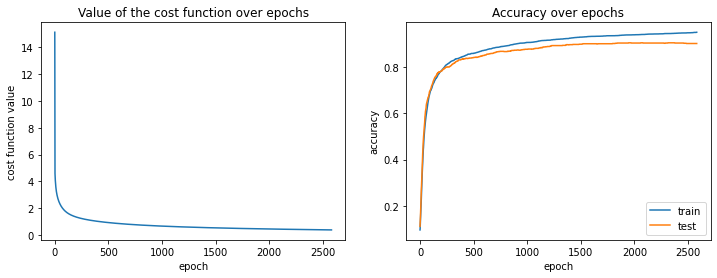

Train accuracy: 0.95175
Test accuracy: 0.903


In [255]:
NN = NeuralNetwork(df, 50)
NN.gradientDescent(alpha=1e-4, threshold=1e-4, epochs=3000)
NN.plotCostAccuracy()
print("Train accuracy:", NN.accuracy(NN.X_train, NN.labels_train))
print("Test accuracy:", NN.accuracy(NN.X_test, NN.labels_test))

As we can see the cost function converges as the gradient descent stopped due to the $10^{-4}$ threshold (before 3000 epochs).

The accuracy of train and test are relativelly closed, even if there is a difference of 0.05.

### 3.3. Test Classifier 

We can use our model to try to predict some images:

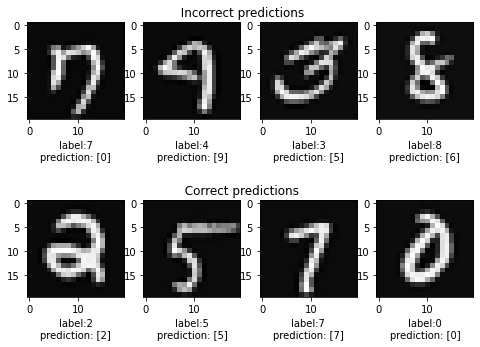

In [279]:
list_images = [3546,2171 , 1601, 4415, 1458, 2914, 3509, 401]
plt.figure(figsize=(8, 6))

for i in range(8):
    im = list_images[i]
    obs = df.iloc[im, :-1]
    label = df.iloc[im, -1]
    plt.subplot(241 + i)
    plt.imshow(obs.values.reshape(20, 20, order="F"), cmap="gray")
    x_label = "label:" + str(label) + "\nprediction: " + str(NN.predict(NN.normalizeFeatures(obs).T))
    plt.xlabel(x_label)
    if(i==1): plt.title("                          Incorrect predictions")
    if(i==5): plt.title("                          Correct predictions")

plt.show()

As the accuracy of the test dataset is around 0.9, it means that we predict 9 times out of 10 a correct value.   
Above, we selected tricky observations, our model seems to mismatch 4 and 9 for example. 

### 3.4. Performance

Let's compare the confusion matrix of train and test set:

In [273]:
print("Train \naccuracy:", NN.accuracy(NN.X_train, NN.labels_train))
print("confusion matrix:\n", NN.confusion(NN.X_train, NN.labels_train))

print("\nTest \naccuracy:", NN.accuracy(NN.X_test, NN.labels_test))
print("confusion matrix:\n", NN.confusion(NN.X_test, NN.labels_test))

Train 
accuracy: 0.95175
confusion matrix:
 [[381   0   0   2   0   1   3   0   1   1]
 [  0 387   1   2   2   0   0   0   3   0]
 [  1   1 371   4   7   1   2   2   6   0]
 [  2   3   4 383   2  12   0   5   3   1]
 [  0   1   3   0 391   0   3   1   0   7]
 [  3   0   3   8   1 377   4   1   5   0]
 [  0   3   0   0   1   4 394   0   0   0]
 [  2   3   6   0   3   0   0 369   1   4]
 [  0   7   4   6   3   5   4   0 387   3]
 [  3   1   0   2   3   3   2   6   2 367]]

Test 
accuracy: 0.903
confusion matrix:
 [[106   0   0   0   0   1   2   0   1   1]
 [  0 100   1   0   0   4   0   0   0   0]
 [  1   0  94   4   3   0   1   0   1   1]
 [  0   0   3  74   1   2   1   1   2   1]
 [  0   0   2   0  83   0   3   0   1   5]
 [  2   0   0   1   1  90   1   0   3   0]
 [  2   0   4   0   2   1  88   0   1   0]
 [  1   2   3   1   2   0   0 100   1   2]
 [  1   1   0   3   0   1   2   0  73   0]
 [  0   0   1   1   5   1   0   5   3  95]]


For the confusion matrix: the rows represent the true labels whereas the columns represent the predictions.   
The correct prediction are represented in the diagonal. 

Let's take an example :   
If we take the confusion matrix of the train set, the value 6 is at row 8 and column 3.   
It means that there are 16 incorrect predictions : the model predicts 3 instead of 8. 

Thanks to the confusion matrix, we can state that the model seems to confuse some numbers: 
- 3 with 8 
- 9 with 4 
- 3 with 5 

Let's see if we can improve it by using a Deep Neural Network.

## 4. Generalization to DeepNeuralNetwork

We can now generalize our Neural Network in order to implement a DeepNeuralNetwork with as many layers as we want.  
Once again, we create a class called **DeepNeuralNetwork**, which uses and adapts the functions created in the **NeuralNetwork** class.

Let's see the modifications brought by the **DeepNeuralNetwork**. The previous NeuralNetwork was working for 3 layers : one input, one hidden and one output layer.

### 4.1. Initialisation 

For the DeepNeuralNetwork, one have to initiate `n_neurons`: a list of number of neurons for each hidden layer.  
For example: `n_neurons = [50,50,50]` means that we have 5 layers: one input layer, three hidden layers of 50 neurons and one output layer.

``` python
    self.layers = []
    self.layers.append(InputLayer())
    prev_n = self.n
    for n in n_neurons:
        self.layers.append(Layer(prev_n, n))
        prev_n = n
    self.layers.append(OutputLayer(prev_n, self.n_classes))
```

### 4.2. Forward and Backward propagation 

#### Forward

We have to do the forward propagation from the input layer to the output layer. 
As each layer use the output of the previous layer to complete forward propagation, 
we just have to do a `for` loop and reuse the result of the previous layer stored in `inputs`. 

``` python
    inputs = x
    for l in range(len(self.layers)):
        self.layers[l].forward(inputs)
        inputs = self.layers[l].output
```

#### Backward

Whereas for the backward propagation, we have to go from the output layer to the input layer. 
We start by doing the backward propagation of the output layer, and then do a `for` to do the backward propagation of 
all the hidden layers.
We use the backward function created in the Layer class and its child class, which actualizes the error.
We store the weight at each layer in`next_w` and the associated error in `next_error`.

``` python
    self.layers[-1].backward(self.y_train)
    next_w, next_error = self.layers[-1].w, self.layers[-1].error
    for l in range(len(self.layers) - 2, 0, -1):
        self.layers[l].backward(next_w, next_error)
        next_w, next_error = self.layers[l].w, self.layers[l].error
```

### 4.3. Gradient

To calculate the global gradient, we calculate the gradient of each output and hidden layers.   
So we use a `for` loop to do the calculation.

```python
    grads = []
    for l in range(len(self.layers) - 1):
        grads.append(self.layers[l + 1].error * self.layers[l].output.T)

    return grads
```

### 4.4. Code of the DeepNeuralNetwork

In [12]:
class DeepNeuralNetwork:
    def __init__(self, df, n_neurons, test_size=0.2, random_state=42):
        X = df.iloc[:, :-1]
        y = df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        self.m, self.n = X_train.shape
        self.n_classes = y.nunique()
        
        self.X_train = self.normalizeFeatures(X_train, fit=True).T
        self.X_test = self.normalizeFeatures(X_test).T
        self.y_train = np.matrix(pd.get_dummies(y_train)).T
        self.labels_train = np.matrix(y_train)
        self.y_test = np.matrix(pd.get_dummies(y_test)).T
        self.labels_test = np.matrix(y_test)
        
        self.layers = []
        self.layers.append(InputLayer())
        prev_n = self.n
        for n in n_neurons:
            self.layers.append(Layer(prev_n, n))
            prev_n = n
        self.layers.append(OutputLayer(prev_n, self.n_classes))

    def normalizeFeatures(self, X, fit=False):
        if fit:
            scaling = list(zip(X.min(), X.max()))
            self.scaling = list(map(lambda x: (0, 1) if x[0] == x[1] else (x[0], x[1]), scaling))

        minmax = list(zip(*self.scaling))
        min, max = np.array(minmax[0]), np.array(minmax[1])
        
        return np.matrix((X - min) / (max - min))

    def gradientDescent(self, alpha=1e-3, threshold=1e-5, epochs=1000):
        i = 0
        self.J = []
        self.train_accuracy = []
        self.test_accuracy = []
    
        while True:
            i += 1
            self.forward(self.X_train)
            self.backward()
        
            self.J.append(self.costFunction(self.layers[-1].output))

            grads = self.gradient()
            
            for l in range(len(self.layers) - 1):
                self.layers[l + 1].w -= alpha * grads[l]
                
            self.train_accuracy.append(self.accuracy(self.X_train, self.labels_train))
            self.test_accuracy.append(self.accuracy(self.X_test, self.labels_test))
            
            if len(self.J) > 1:
                if abs(self.J[-1] - self.J[-2]) < threshold or i == epochs:
                    break

    def plotCostAccuracy(self):
        try:
            plt.figure(figsize=(12, 4))
            plt.subplot(121)
            plt.plot(self.J)
            plt.title("Value of the cost function over epochs")
            plt.xlabel("epoch")
            plt.ylabel("cost function value")
            
            plt.subplot(122)
            plt.plot(self.train_accuracy, label="train")
            plt.plot(self.test_accuracy, label="test")
            plt.title("Accuracy over epochs")
            plt.xlabel("epoch")
            plt.ylabel("accuracy")
            plt.legend()
            plt.show()
        except AttributeError:
            print("No gradient descent was performed")

    def costFunction(self, y_pred):
        y, m = self.y_train, self.m
    
        return -1 / m * np.sum(np.multiply(y, np.log(y_pred)) + np.multiply((1 - y), np.log(1 - y_pred)))

    def forward(self, x):
        inputs = x
        for l in range(len(self.layers)):
            self.layers[l].forward(inputs)
            inputs = self.layers[l].output

    def backward(self):
        self.layers[-1].backward(self.y_train)
        next_w, next_error = self.layers[-1].w, self.layers[-1].error
        for l in range(len(self.layers) - 2, 0, -1):
            self.layers[l].backward(next_w, next_error)
            next_w, next_error = self.layers[l].w, self.layers[l].error

    def gradient(self):
        grads = []
        for l in range(len(self.layers) - 1):
            grads.append(self.layers[l + 1].error * self.layers[l].output.T)

        return grads
    
    def confusion(self, X, y):
        y_pred = self.predict(X)
        
        matrix = np.zeros((self.n_classes, self.n_classes), dtype=int)
        
        for i in range(len(y_pred)):
            matrix[y.T[i], y_pred[i]] += 1
        
        return matrix

    def accuracy(self, X, y):
        return (self.predict(X) == y).mean()
        
    def predict(self, X):
        self.forward(X)
        return np.array(self.layers[-1].output).argmax(axis=0)

## 5. Applying the DNN algorithm to the dataset

Using one hidden layer of 50 neurons, we obtain the following results:


DNN 1 hidden layer
Train accuracy: 0.9075
Test accuracy: 0.878


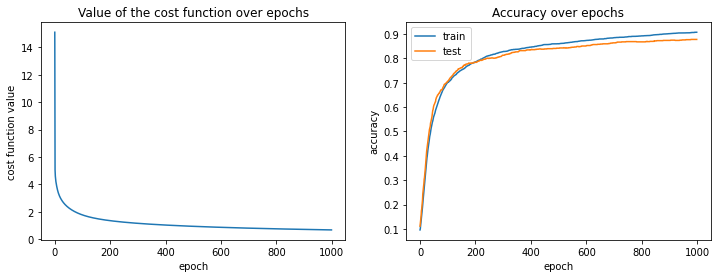

In [280]:
DNN1 = DeepNeuralNetwork(df, [50])
DNN1.gradientDescent(alpha=1e-4, epochs=1000)
print("\nDNN 1 hidden layer")
print("Train accuracy:", DNN1.accuracy(DNN1.X_train, DNN1.labels_train))
print("Test accuracy:", DNN1.accuracy(DNN1.X_test, DNN1.labels_test))
DNN1.plotCostAccuracy()

We obtain the same result as with the FFNN. 

### 5.1. Compare DNN with layers of same numbers of neurons

Let's add some hidden layers in a FFNN and see the difference of accuracy for train and test.

#### Two Hidden Layers

With two hidden layers, we obtain the following results:


DNN 2 hidden layers
Train accuracy: 0.91825
Test accuracy: 0.862


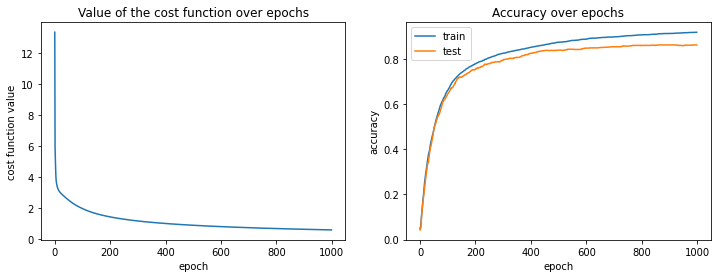

In [281]:
DNN2 = DeepNeuralNetwork(df, [50, 50])
DNN2.gradientDescent(alpha=1e-4, epochs=1000)
print("\nDNN 2 hidden layers")
print("Train accuracy:", DNN2.accuracy(DNN2.X_train, DNN2.labels_train))
print("Test accuracy:", DNN2.accuracy(DNN2.X_test, DNN2.labels_test))
DNN2.plotCostAccuracy()

Compare to the DNN with only one hidden layers, the train accuracy (0.91) of the two hidden layer DNN is higher of 0.01 but the test accuracy (0.86) is 
lower of 0.016.   
We can conclude that the train accuracy is better for two hidden layers, but the test one does not get better. The difference between the two of them is around 0.056 whereas it was around 0.029 for DNN with one hidden layer.

We can add more layers to see if the gap is widening between train and test accuracies.

#### Three Hidden Layers

With three hidden layers, we obtain the following results:


DNN 3 hidden layers
Train accuracy: 0.934
Test accuracy: 0.88


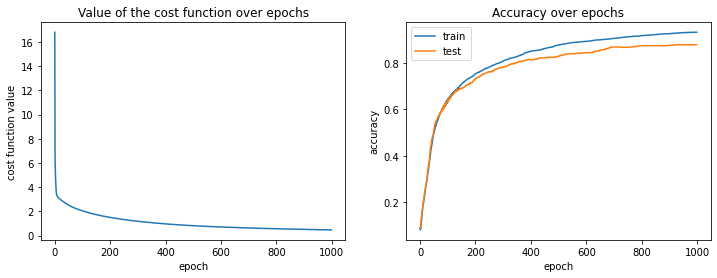

In [282]:
DNN3 = DeepNeuralNetwork(df, [50, 50, 50])
DNN3.gradientDescent(alpha=1e-4, epochs=1000)
print("\nDNN 3 hidden layers")
print("Train accuracy:", DNN3.accuracy(DNN3.X_train, DNN3.labels_train))
print("Test accuracy:", DNN3.accuracy(DNN3.X_test, DNN3.labels_test))
DNN3.plotCostAccuracy()

Once again if we compare the train and test accuracy, the gap between them is more important than
the one with two hidden layers. There is **overfitting**.

### 5.2. Comparison

By plotting them on the same plot we obtain for train and test dataset:

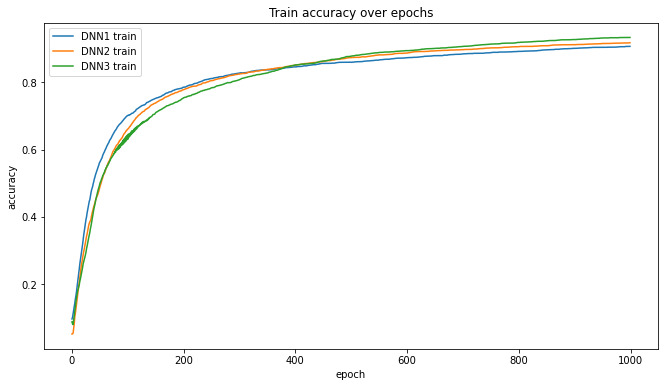

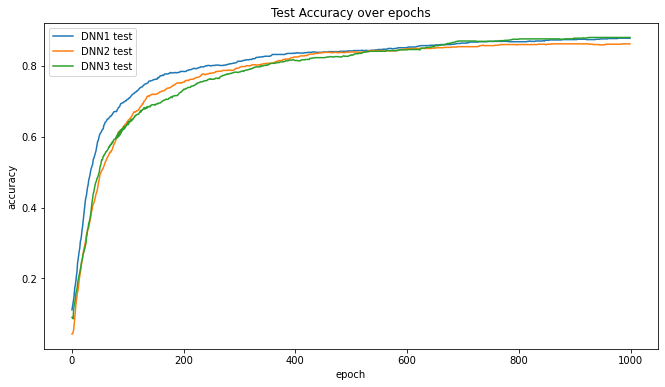

In [293]:
plt.figure(figsize=(11, 6))

plt.plot(DNN1.train_accuracy, label="DNN1 train")
plt.plot(DNN2.train_accuracy, label="DNN2 train")
plt.plot(DNN3.train_accuracy, label="DNN3 train")

plt.title("Train accuracy over epochs")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(11, 6))

plt.plot(DNN1.test_accuracy, label="DNN1 test")
plt.plot(DNN2.test_accuracy, label="DNN2 test")
plt.plot(DNN3.test_accuracy, label="DNN3 test")

plt.title("Test Accuracy over epochs")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

We obtain the following accuracies. Result columns represents the difference between train and test accuracy.

|                 | Train  accuracy   |  Test accuracy |  Results  |
|-----------------|:-----------------:|:--------------:|:---------:|
| **DNN 1**       |       0.9075      |       0.878    |  0.0295   |
| **DNN 2**       |       0.91825     |       0.862    |  0.0525   |
| **DNN 3**       |       0.934       |       0.88     |  0.054    |<br><br>


We clearly see that increasing the number of hidden layers increases a little bit the train accuracy but globally, 
the test accuracy does not change. So it creates overfitting. 

As the first DNN had a correct train accuracy, adding hidden layers did not bring better results for the test. 
It means that only one hidden layer explains our dataset.

We can now create our final DNN of one hidden layer with **50** neurons going through 3000 epochs (until convergence).


DNN 1 hidden layer
Train accuracy: 0.95175
Test accuracy: 0.903


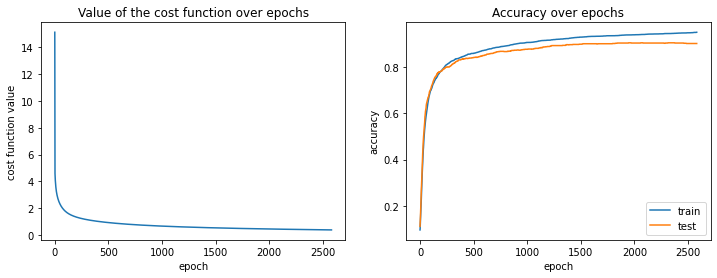

In [291]:
DNN = DeepNeuralNetwork(df,[50])
DNN.gradientDescent(alpha=1e-4, threshold = 1e-4, epochs=3000)
print("\nDNN 1 hidden layer")
print("Train accuracy:", DNN.accuracy(DNN.X_train, DNN.labels_train))
print("Test accuracy:", DNN.accuracy(DNN.X_test, DNN.labels_test))
DNN.plotCostAccuracy()

## 7. Compare to Keras 

### 7.1. Keras model

Using Keras, let's create a DNN with only one hidden layer of 50 neurons.

In [286]:
model = Sequential()
model.add(Dense(50, input_dim=400, activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, train_labels, test_labels = train_test_split(X,y,test_size=0.2, random_state=42)

y_train = pd.get_dummies(train_labels)
y_test = pd.get_dummies(test_labels)

history = model.fit(X_train, y_train, epochs=3000, batch_size=128)

32/32 [==============================] - 0s 1ms/step - loss: 0.1429 - accuracy: 0.9613
Epoch 2502/3000
32/32 [==============================] - 0s 2ms/step - loss: 0.1517 - accuracy: 0.9614
Epoch 2503/3000
32/32 [==============================] - 0s 1ms/step - loss: 0.1216 - accuracy: 0.9707
Epoch 2504/3000
32/32 [==============================] - 0s 2ms/step - loss: 0.1346 - accuracy: 0.9668
Epoch 2505/3000
32/32 [==============================] - 0s 2ms/step - loss: 0.1335 - accuracy: 0.9641
Epoch 2506/3000
32/32 [==============================] - 0s 2ms/step - loss: 0.1387 - accuracy: 0.9649
Epoch 2507/3000
32/32 [==============================] - 0s 2ms/step - loss: 0.1432 - accuracy: 0.9660
Epoch 2508/3000
32/32 [==============================] - 0s 1ms/step - loss: 0.1393 - accuracy: 0.9634
Epoch 2509/3000
32/32 [==============================] - 0s 2ms/step - loss: 0.1267 - accuracy: 0.9706
Epoch 2510/3000
32/32 [==============================] - 0s 1ms/step - loss: 0.1390 - acc

### 7.2. Comparison 

We can now compare accuracy and confusion matrix of Keras model to our DNN model.

In [290]:
print("Keras:")
accuracy_keras = model.evaluate(X_test, y_test, verbose = 0)[1]
print("Test accuracy: ", accuracy_keras)
rounded_predictions = np.argmax(model.predict(X_test), axis=-1)
print(confusion_matrix(test_labels, rounded_predictions))

print("\nDNN:")
print("Test accuracy: ",DNN.accuracy(DNN.X_test, DNN.labels_test))
print(DNN.confusion(DNN.X_test, DNN.labels_test))

Keras:
Test accuracy:  0.9229999780654907
[[109   0   0   0   0   1   0   0   0   1]
 [  0 101   1   0   0   2   0   0   0   1]
 [  1   1  91   3   5   1   1   1   1   0]
 [  0   0   3  76   0   1   1   1   2   1]
 [  0   0   2   0  84   0   2   0   1   5]
 [  0   2   0   0   1  93   0   0   1   1]
 [  2   0   0   0   0   2  93   0   1   0]
 [  1   3   2   0   2   0   0 100   0   4]
 [  1   2   1   0   0   4   1   0  72   0]
 [  0   0   0   2   0   1   0   3   1 104]]

DNN:
Test accuracy:  0.903
[[106   0   0   0   0   1   2   0   1   1]
 [  0 100   1   0   0   4   0   0   0   0]
 [  1   0  94   4   3   0   1   0   1   1]
 [  0   0   3  74   1   2   1   1   2   1]
 [  0   0   2   0  83   0   3   0   1   5]
 [  2   0   0   1   1  90   1   0   3   0]
 [  2   0   4   0   2   1  88   0   1   0]
 [  1   2   3   1   2   0   0 100   1   2]
 [  1   1   0   3   0   1   2   0  73   0]
 [  0   0   1   1   5   1   0   5   3  95]]


Comparing the predictions of our model to the one of Keras model, the accuracy of the Keras DNN 
is a little bit higher than the one from our model. There is a small difference of 0.019.  
This difference can be explained by many factors such as the batches or the weights initialization.

The confusion matrices are similar, even if Keras model better predicts some values such as: 0, 5, 6 and 9. 
But models still confuse some numbers: 9 with 4 and 3 with 5.  

## Conclusion 

This project aims to understand the principle of the feed-forward neural network (FFNN) by implementing
one from scratch.
Building our own models required us to fully understand the principle: activation function, bias and weights, forward and backward propagation. 
It was very interesting to go further in machine learning and realise how models as complicated as neural networks work from the inside. 

For the future, as we have implemented classes for layers and neural network, we could improve and generalize them in order to choose the activation function for example.  
We also had the idea to add functions to export our models (save weights in a file) and load them back. This is useful to avoid training the model everytime as it is time-consuming.